In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [284]:
# list of elements with name as key and [total electrons, valence electrons, usually used for bonds] as value
elemList = {'C':[6,4,4],'N':[7,5,3],'O':[8,6,2],'P':[15,5,3],'S':[16,6,2], 'Si':[14,4,4], 'Cl':[17,7,1]} # 'Si':[14,4,4],'Cl':[17,7,1]
components = "CNOPS"
# number of charges we are sampling through
chargeList = range(-2,3)
# number of H atoms we are sampling through
hList = range(0,5)
            
class ligand():
    def __init__(self, name, numberOfHs, charge):
        self.name = name
        self.charge = charge
        self.numberOfHs = numberOfHs
        self.numberOfEs = self.getNumE()
        self.getNumE()
        
    def print_name(self):
        print(self.name)
    
    def print_charge(self):
        print(self.charge)
    
    def print_numberOfHs(self):
        print(self.numberOfHs)
    
    # CHARGES
    def setCharge(self,charge):
        self.charge = charge
        self.getNumE()
        
    def incrCharge(self):
        self.charge += 1
        self.getNumE()
        
    def decrCharge(self):
        self.charge -= 1
        self.getNumE()
        
    # HYDROGENS    
    def setH(self, number):
        self.numberOfHs = number
        self.getNumE()
    
    def addH(self):
        self.numberOfHs += 1
        self.getNumE()
        
    def rmH(self):
        self.numberOfHs -= 1
        self.getNumE()
        
    def getNumE(self):
        self.numLP = int((elemList[self.name][1] - elemList[self.name][2])/2)
        self.numValE = elemList[self.name][1]
        self.numE = elemList[self.name][0]
        mod = self.numberOfHs - self.charge
        self.numValE += mod
        self.numE += mod
        
    def getSmiles(self):
        """Generates a SMILES string. The first row adds hydrogen and the second row charges"""
        self.SMILES =  "[" + self.name + "".join(["H" for i in range(0,self.numberOfHs)]) 
        self.SMILES += "".join(["+" if self.charge > 0  else "-" for i in range(0,abs(self.charge))]) + "]"
    
    def testOctetRule(self):
        """Test whether a mono-heavy-atom ligand fulfills the octet rule. Results < 8 means that there are 
        too many electrons, result > 8 means that there are not enough electrons."""
        result = 8 - self.numValE
        return(result)
    
    def testValenceShell(self):
        """Since open shell complexes are difficult to converge in DFT, we restrict ourselves to closed shell ones."""
        result =  int(not self.numValE%2)
        return(result)
        
    def score(self):
        """The health score helps to prune the full enumeration by setting open shell ligands to zero and 
        weights ligands with negative charge more than ligands with positive charge. Greater is better in this
        score."""
        score = (10-(-2*self.testOctetRule() if self.testOctetRule() < 0 else self.testOctetRule())) #*self.testValenceShell() # removed the testValshell bc it is only relevant for the whole ligand
        return(score)
    
    

In [285]:
# generate exhaustive output list for mono-ligands
outputList = list()
for elem in elemList.keys():
    for charge in chargeList:
        l = ligand(elem, 0, 0)
        l.setCharge(charge)
        for h in hList:
            if h:
                l.addH()
            l.getSmiles()
            outputList.append([l.SMILES,l.numE,l.numValE,l.charge,l.testOctetRule(),l.testValenceShell(),l.score()]) 


30625
[['[C--]', 8, 6, 0, -2, 0, 2, 1, 8, '[C--]', 8, 6, 0, -2, 0, 2, 1, 8], 16.0]
[['[C--]', 8, 6, 0, -2, 0, 2, 1, 8, '[CHH--]', 10, 8, 0, -2, 2, 0, 1, 10], 15.0]
[['[C--]', 8, 6, 0, -2, 0, 2, 1, 8, '[CHHHH--]', 12, 10, 0, -2, 4, -2, 1, 6], 11.0]
[['[CH--]', 9, 7, 0, -2, 1, 1, 0, 9, '[CH--]', 9, 7, 0, -2, 1, 1, 0, 9], 17.0]
[['[CH--]', 9, 7, 0, -2, 1, 1, 0, 9, '[CHHH--]', 11, 9, 0, -2, 3, -1, 0, 8], 14.5]
[['[CHH--]', 10, 8, 0, -2, 2, 0, 1, 10, '[C--]', 8, 6, 0, -2, 0, 2, 1, 8], 15.0]
[['[CHH--]', 10, 8, 0, -2, 2, 0, 1, 10, '[CHH--]', 10, 8, 0, -2, 2, 0, 1, 10], 18.0]
[['[CHH--]', 10, 8, 0, -2, 2, 0, 1, 10, '[CHHHH--]', 12, 10, 0, -2, 4, -2, 1, 6], 14.0]
[['[CHHH--]', 11, 9, 0, -2, 3, -1, 0, 8, '[CH--]', 9, 7, 0, -2, 1, 1, 0, 9], 13.5]
[['[CHHH--]', 11, 9, 0, -2, 3, -1, 0, 8, '[CHHH--]', 11, 9, 0, -2, 3, -1, 0, 8], 15.0]
[['[CHHHH--]', 12, 10, 0, -2, 4, -2, 1, 6, '[C--]', 8, 6, 0, -2, 0, 2, 1, 8], 9.0]
[['[CHHHH--]', 12, 10, 0, -2, 4, -2, 1, 6, '[CHH--]', 10, 8, 0, -2, 2, 0, 1, 10], 1

[['[NHHHH-]', 12, 10, 1, -1, 4, -2, 1, 6, '[CHH++]', 6, 4, 0, 2, 2, 4, 1, 6], 9.0]
[['[NHHHH-]', 12, 10, 1, -1, 4, -2, 1, 6, '[CHHHH++]', 8, 6, 0, 2, 4, 2, 1, 8], 12.0]
[['[N]', 7, 5, 1, 0, 0, 3, 0, 7, '[CH--]', 9, 7, 0, -2, 1, 1, 0, 9], 19.0]
[['[N]', 7, 5, 1, 0, 0, 3, 0, 7, '[CHHH--]', 11, 9, 0, -2, 3, -1, 0, 8], 16.5]
[['[NH]', 8, 6, 1, 0, 1, 2, 1, 8, '[C--]', 8, 6, 0, -2, 0, 2, 1, 8], 17.0]
[['[NH]', 8, 6, 1, 0, 1, 2, 1, 8, '[CHH--]', 10, 8, 0, -2, 2, 0, 1, 10], 20.0]
[['[NH]', 8, 6, 1, 0, 1, 2, 1, 8, '[CHHHH--]', 12, 10, 0, -2, 4, -2, 1, 6], 16.0]
[['[NHH]', 9, 7, 1, 0, 2, 1, 0, 9, '[CH--]', 9, 7, 0, -2, 1, 1, 0, 9], 18.0]
[['[NHH]', 9, 7, 1, 0, 2, 1, 0, 9, '[CHHH--]', 11, 9, 0, -2, 3, -1, 0, 8], 19.5]
[['[NHHH]', 10, 8, 1, 0, 3, 0, 1, 10, '[C--]', 8, 6, 0, -2, 0, 2, 1, 8], 15.0]
[['[NHHH]', 10, 8, 1, 0, 3, 0, 1, 10, '[CHH--]', 10, 8, 0, -2, 2, 0, 1, 10], 18.0]
[['[NHHH]', 10, 8, 1, 0, 3, 0, 1, 10, '[CHHHH--]', 12, 10, 0, -2, 4, -2, 1, 6], 18.0]
[['[NHHHH]', 11, 9, 1, 0, 4, -1, 0,

[['[PHHHH]', 19, 9, 1, 0, 4, -1, 0, 8, '[P]', 15, 5, 1, 0, 0, 3, 0, 7], 12.5]
[['[PHHHH]', 19, 9, 1, 0, 4, -1, 0, 8, '[PHH]', 17, 7, 1, 0, 2, 1, 0, 9], 15.5]
[['[PHHHH]', 19, 9, 1, 0, 4, -1, 0, 8, '[PHHHH]', 19, 9, 1, 0, 4, -1, 0, 8], 17.0]
[['[P]', 15, 5, 1, 0, 0, 3, 0, 7, '[PH+]', 15, 5, 1, 1, 1, 3, 0, 7], 14.0]
[['[P]', 15, 5, 1, 0, 0, 3, 0, 7, '[PHHH+]', 17, 7, 1, 1, 3, 1, 0, 9], 13.0]
[['[PH]', 16, 6, 1, 0, 1, 2, 1, 8, '[P+]', 14, 4, 1, 1, 0, 4, 1, 6], 14.0]
[['[PH]', 16, 6, 1, 0, 1, 2, 1, 8, '[PHH+]', 16, 6, 1, 1, 2, 2, 1, 8], 15.0]
[['[PH]', 16, 6, 1, 0, 1, 2, 1, 8, '[PHHHH+]', 18, 8, 1, 1, 4, 0, 1, 10], 14.0]
[['[PHH]', 17, 7, 1, 0, 2, 1, 0, 9, '[PH+]', 15, 5, 1, 1, 1, 3, 0, 7], 15.0]
[['[PHH]', 17, 7, 1, 0, 2, 1, 0, 9, '[PHHH+]', 17, 7, 1, 1, 3, 1, 0, 9], 16.0]
[['[PHHH]', 18, 8, 1, 0, 3, 0, 1, 10, '[P+]', 14, 4, 1, 1, 0, 4, 1, 6], 12.0]
[['[PHHH]', 18, 8, 1, 0, 3, 0, 1, 10, '[PHH+]', 16, 6, 1, 1, 2, 2, 1, 8], 15.0]
[['[PHHH]', 18, 8, 1, 0, 3, 0, 1, 10, '[PHHHH+]', 18, 8, 1, 1

[['[SHHHH++]', 18, 8, 2, 2, 4, 0, 1, 10, '[SiH-]', 16, 6, 0, -1, 1, 2, 1, 8], 10.0]
[['[SHHHH++]', 18, 8, 2, 2, 4, 0, 1, 10, '[SiHHH-]', 18, 8, 0, -1, 3, 0, 1, 10], 13.0]
[['[S++]', 14, 4, 2, 2, 0, 4, 1, 6, '[Si]', 14, 4, 0, 0, 0, 4, 1, 6], 12.0]
[['[S++]', 14, 4, 2, 2, 0, 4, 1, 6, '[SiHH]', 16, 6, 0, 0, 2, 2, 1, 8], 15.0]
[['[S++]', 14, 4, 2, 2, 0, 4, 1, 6, '[SiHHHH]', 18, 8, 0, 0, 4, 0, 1, 10], 14.0]
[['[SH++]', 15, 5, 2, 2, 1, 3, 0, 7, '[SiH]', 15, 5, 0, 0, 1, 3, 0, 7], 13.0]
[['[SH++]', 15, 5, 2, 2, 1, 3, 0, 7, '[SiHHH]', 17, 7, 0, 0, 3, 1, 0, 9], 16.0]
[['[SHH++]', 16, 6, 2, 2, 2, 2, 1, 8, '[Si]', 14, 4, 0, 0, 0, 4, 1, 6], 11.0]
[['[SHH++]', 16, 6, 2, 2, 2, 2, 1, 8, '[SiHH]', 16, 6, 0, 0, 2, 2, 1, 8], 14.0]
[['[SHH++]', 16, 6, 2, 2, 2, 2, 1, 8, '[SiHHHH]', 18, 8, 0, 0, 4, 0, 1, 10], 17.0]
[['[SHHH++]', 17, 7, 2, 2, 3, 1, 0, 9, '[SiH]', 15, 5, 0, 0, 1, 3, 0, 7], 11.0]
[['[SHHH++]', 17, 7, 2, 2, 3, 1, 0, 9, '[SiHHH]', 17, 7, 0, 0, 3, 1, 0, 9], 14.0]
[['[SHHHH++]', 18, 8, 2, 2, 4, 0,

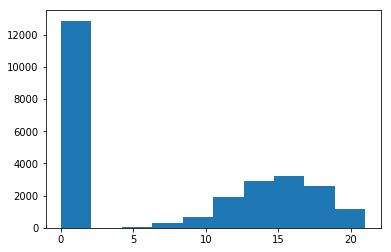

In [288]:
class dualLigand():
    def __init__(self, atom1, atom2):
        self.atom1 = atom1 
        self.atom2 = atom2 

#print([''.join(x) for x in itertools.product('CHNPOS', repeat=2)])

# generate exhaustive output list for di-ligands
outputListDi = list()
for elem1 in elemList.keys():
    for elem2 in elemList.keys():
        for charge1 in chargeList:
            for charge2 in chargeList:
                for h1 in hList:
                    for h2 in hList: 
                        l1 = ligand(elem1, 0, 0)
                        l1.setCharge(charge1)
                        l1.setH(h1)
                        l2 = ligand(elem2, 0, 0)
                        l2.setCharge(charge2)
                        l2.setH(h2)
                        
                        l1.getSmiles()
                        l2.getSmiles()
                        
                        outputListDi.append([l1.SMILES, \
                                             l1.numE, l1.numValE, l1.numLP, l1.charge, l1.numberOfHs, \
                                             l1.testOctetRule(), l1.testValenceShell(), l1.score(),\
                                             l2.SMILES,
                                             l2.numE, l2.numValE, l2.numLP, l2.charge, l2.numberOfHs, \
                                             l2.testOctetRule(), l2.testValenceShell(), l2.score()])

print(len(outputListDi))

## list that have the same ready electrons (re). re are electrons that are "unused" in the valence shell.
# reequalList = []
# i = 0
# for line in outputListDi:
#     re1 = line[2]  - 2*line[5]
#     re2 = line[11] - 2*line[14] 
#     if re1 == re2:
#         reequalList.append(line)
#         i = i+1
# print(len(reequalList))

## only negatively charged ligands
outputListDiNeg = []
scoreDiNeg = []
for line in outputListDi:
    # only consider negatively charged di-heavy-atoms
    if line[4] <= 0 or line[13] <= 0:
        # higher is better
        scoreCharge = 3 if line[4] + line[13] >= -2 else line[4] + line[13] + 4
        scoreCharge -= 3 if line[4] + line[13] > 0 else 0

        usual1 = line[2] - 2*line[3] + line[4] - 2*line[5]
        usual2 = line[11] - 2*line[12] + line[13] - 2*line[14]
        scoreVsepr = 5-np.abs(usual1-usual2)
        
        # THEY ARENT[[since both AB and BA is created, we remove the ones that are A=B]]
        # the first atom is the CA and we punish >=3 H on it.
        if line[5] == 4:
            scoreCa = 1
        elif line[5] == 3:
            scoreCa = 2
        else:
            scoreCa = 3
        
        scoreClosedShell = int(not((line[2]+line[11])%2))

        score = (scoreCharge + scoreVsepr + scoreCa + 0.5 * line[8] + 0.5 * line[17])*scoreClosedShell
        scoreDiNeg.append(score)
        
        outputListDiNeg.append([line,score])
    else:
        continue

# gives 5625 (total 15625 * 9/25, since there are 25 comb of [-2,+2], 9 of which contain a pos sign)    

# for s in outputListDiNeg:
#     print(*s)
k=0
score = np.zeros(len(outputListDiNeg))
for i in range(0, len(outputListDiNeg)):
    score[i] = outputListDiNeg[i][1]
    if score[i] >1:
        k += 1
        print(outputListDiNeg[i])
print(k)    
plt.hist(score)
plt.show()

In [232]:


# create list of isoelectronic ligands and ve-isoelectronig ligands (ligands that have the same amount of VE)
isoList = []  
veList = []
score = []
for line in outputList:
    isoList.append(line[1]) # unsorted list of the total amount of e
    veList.append(line[2]) # unsorted list of the amount of VE
    score.append(line[-1])

isoLigands = {} # dictionary of ligands with key: number of electrons, values: the whole output
d = dict()
for i in np.unique(isoList):
    d[i] = []

for line in outputList:
    d[line[1]].append(line)

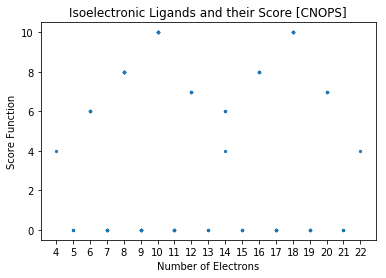

In [233]:
# plot of score function vs number of total electrons. It seems like the number of electrons determines the score fullz.
plt.scatter(isoList, score, s = 5)
plt.xlabel('Number of Electrons')
plt.ylabel('Score Function')
plt.title('Isoelectronic Ligands and their Score ['+ components + "]")
plt.xticks(np.unique(isoList))
plt.savefig('score_iso_ligands_' + components + ".pdf", bbox_inches='tight')


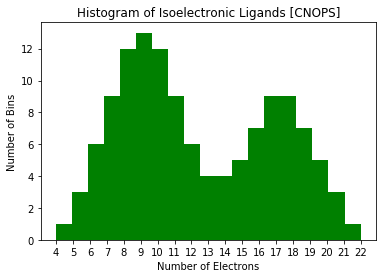

In [313]:
# plot the number of ligands sorted by the number of electrons (isoelectronic structures)

numBins = len(np.unique(isoList))

plt.hist(isoList, bins = numBins, facecolor='green')
plt.xlabel('Number of Electrons')
plt.ylabel('Number of Bins')
plt.title('Histogram of Isoelectronic Ligands ['+ components + "]")
plt.xticks(np.unique(isoList))
plt.savefig('hist_iso_ligands_' + components + ".pdf", bbox_inches='tight')
plt.show()


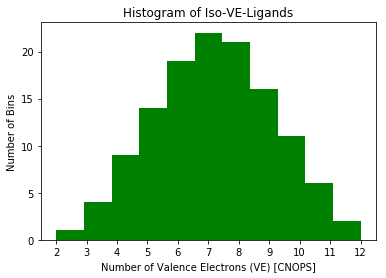

In [234]:
# plot the number of ligands sorted by the number of VE (VE-isoelectronic structures)

numBins = len(np.unique(veList))

plt.hist(veList, bins = numBins, facecolor='green')
plt.xlabel('Number of Valence Electrons (VE) ['+ components + "]")
plt.ylabel('Number of Bins')
plt.title('Histogram of Iso-VE-Ligands')
plt.xticks(np.unique(veList))
plt.savefig('hist_isove_ligands_' + components + ".pdf", bbox_inches='tight')
plt.show()


In [256]:
6%2

0